In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
torch.manual_seed(13)
np.random.seed(13)
model = models_pheno.MassiveConvNet

# for trial_idx in tqdm(range(n_trials)):
def get_sgd_path(net, n_epochs=9):
    opt = torch.optim.Adam(net.parameters(), lr=1e-2)
    vecs = []
    loop = tqdm(range(n_epochs), leave=False)
    vecs.append(util.model2vec(net).detach().clone())
    for epoch_idx in loop:
        for X_batch, Y_batch in zip([task.X_train[10000*i:10000*(i+1)] for i in range(6)], [task.Y_train[10000*i:10000*(i+1)] for i in range(6)]):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = task.loss_func(Y_batch_pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

        fitdata = task.calc_pheo_fitness(net, n_sample=None, device=device)
        loop.set_postfix(fitdata)
        vecs.append(util.model2vec(net).detach().clone())
    vecs = torch.stack(vecs).detach()
    return vecs

net = model().to(device)
vecs_n = [get_sgd_path(model().to(device)) for _ in tqdm(range(10))]

In [5]:
vecs1, vecs2 = vecs_n[0], vecs_n[1]
print(task.calc_pheo_fitness(util.vec2model(vecs1[-1], net), None, device, 'train'))
print(task.calc_pheo_fitness(util.vec2model(vecs1[-1], net), None, device, 'test'))
print(task.calc_pheo_fitness(util.vec2model(vecs2[-1], net), None, device, 'train'))
print(task.calc_pheo_fitness(util.vec2model(vecs2[-1], net), None, device, 'test'))

{'fitness': -0.06729349493980408, 'loss': 0.06729349493980408, 'accuracy': 97.97666666666667}
{'fitness': -0.06368113309144974, 'loss': 0.06368113309144974, 'accuracy': 97.87}
{'fitness': -0.09728582948446274, 'loss': 0.09728582948446274, 'accuracy': 97.075}
{'fitness': -0.08631114661693573, 'loss': 0.08631114661693573, 'accuracy': 97.41}


In [6]:
def compare_vec_seqs(vecs1, vecs2):
    a, b = vecs1[:, None], vecs2[None]

    dots = vecs1@vecs2.T
    l2_dists = (a-b).norm(dim=-1)
    sim = torch.cosine_similarity(a, b, dim=-1)
    
    plt.figure(figsize=(20,5))
    plt.subplot(131);plt.imshow(dots.cpu().numpy());plt.title('dots');plt.colorbar()
    plt.subplot(132);plt.imshow(sim.cpu().numpy(), vmin=-1, vmax=1);plt.title('cosine sim');plt.colorbar()
    plt.subplot(133);plt.imshow(l2_dists.cpu().numpy());plt.title('l2 dist');plt.colorbar()
    plt.show()
    
def get_vec_linspace(vec_start, vec_end, num=50):
    return torch.stack([vec_start*(1-i)+vec_end*i for i in torch.linspace(0, 1, num)])

def evaluate_vecs(vecs):
    fds = []
    for vec in tqdm(vecs, leave=False):
        fds.append(task.calc_pheo_fitness(util.vec2model(vec, net), n_sample=None, device=device))
    fds = np.array(fds)
    return fds, util.arr_dict2dict_arr(fds)
    


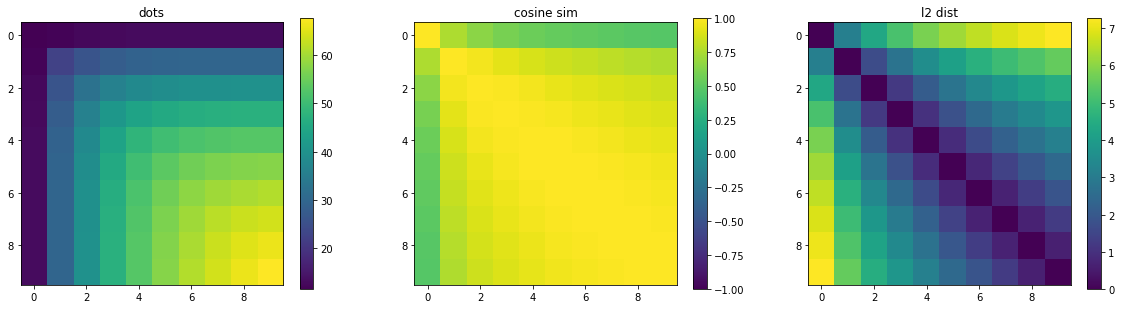

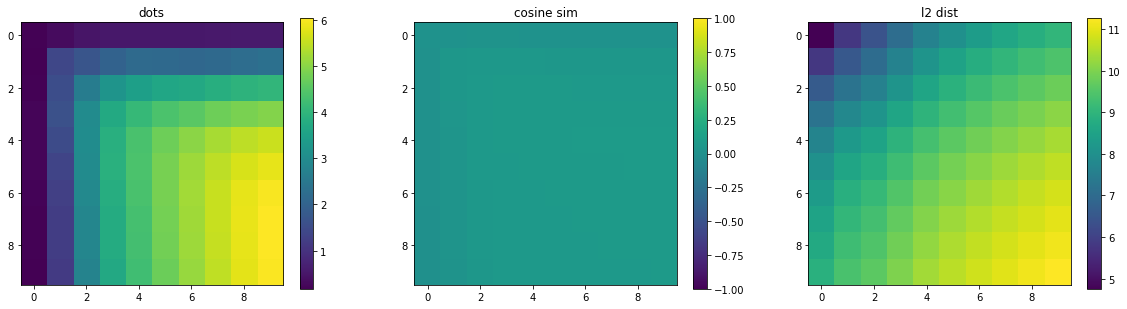

In [9]:
compare_vec_seqs(vecs1, vecs1)
compare_vec_seqs(vecs1, vecs2)

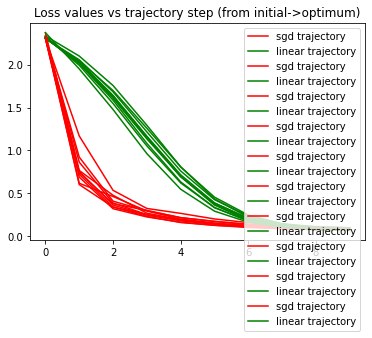

In [11]:
for vecs in tqdm(vecs_n):
    plt.plot(evaluate_vecs(vecs)[1]['loss'], 
             c='r', label='sgd trajectory')
    plt.plot(evaluate_vecs(get_vec_linspace(vecs[0], vecs[-1], len(vecs)))[1]['loss'], 
             c='g', label='linear trajectory')
    
plt.title('Loss values vs trajectory step (from initial->optimum)')
plt.legend()
plt.show()

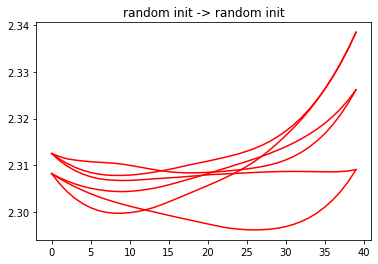

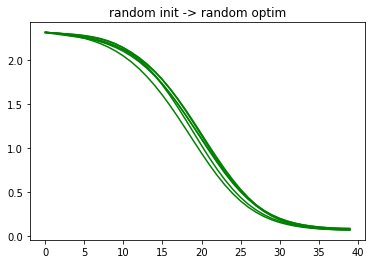

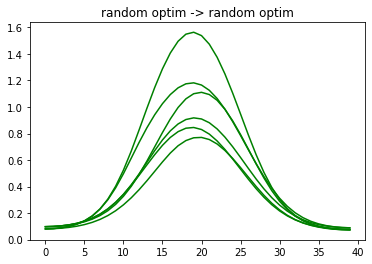

In [13]:
for i in range(1,3):
    for j in range(3, 6):
        _, fds = evaluate_vecs(get_vec_linspace(vecs_n[i][0], vecs_n[j][0], 40))
        plt.plot(fds['loss'], c='r')
plt.title('random init -> random init')
plt.show()
for i in range(1,3):
    for j in range(3, 6):
        _, fds = evaluate_vecs(get_vec_linspace(vecs_n[i][0], vecs_n[j][-1], 40))
        plt.plot(fds['loss'], c='g')
plt.title('random init -> random optim')
plt.show()

for i in range(1,3):
    for j in range(3, 6):
        _, fds = evaluate_vecs(get_vec_linspace(vecs_n[i][-1], vecs_n[j][-1], 40))
        plt.plot(fds['loss'], c='g')
plt.title('random optim -> random optim')
plt.show()

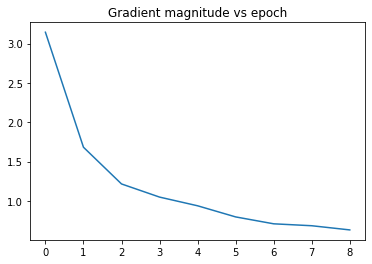

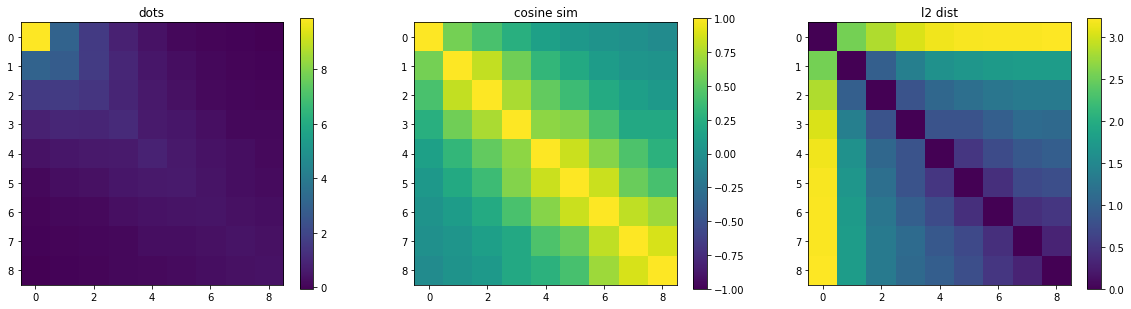

In [18]:
grads = vecs1[1:]-vecs1[:-1]
plt.plot(grads.norm(dim=-1).cpu().numpy())
plt.title('Gradient magnitude vs epoch')
compare_vec_seqs(grads, grads)

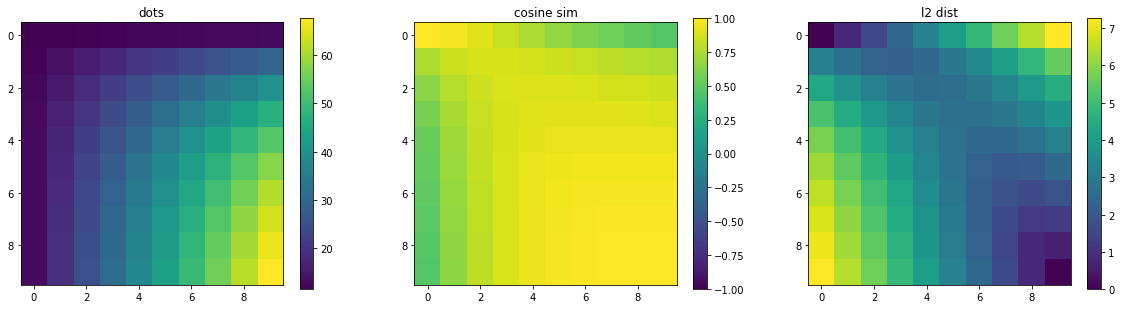

In [19]:
compare_vec_seqs(vecs1, get_vec_linspace(vecs1[0], vecs1[-1], 10))